In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import bayesflow as bf
import tensorflow as tf
from scipy.stats import halfnorm
import sys

In [2]:
sys.path.append("../src")
from observation_model import batched_dynamic_ddm
from priors import rwddm_local_prior, rwddm_hyper_prior, rwddm_shared_prior
from helpers import scale_z, unscale_z

In [3]:
# gpu setting and checking
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-06-06 13:55:08.645409: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-06 13:55:08.728170: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-06 13:55:08.728885: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# Constants

In [61]:
N_SAMPLES = 2000
N_OBS = 150

LOCAL_PARAM_MEANS = 1.7
LOCAL_PARAM_STDS = 1
SHARED_PARAM_MEAN = halfnorm(0.1, 0.2).mean()
SHARED_PARAM_STD = halfnorm(0.1, 0.2).std()
HYPER_PARAM_MEAN = halfnorm(0.0, 0.1).mean()
HYPER_PARAM_STD = halfnorm(0.0, 0.1).std()

LOCAL_PARAM_LABELS = ['Drift rate', 'Threshold']
LOCAL_PARAM_NAMES  = [r'v', r'a']
SHARED_PARAM_LABEL = 'Non-decision time'
SHARED_PARAM_NAME  = r'\tau'
HYPER_PARAM_LABEL = 'Transition std. deviation'
HYPER_PARAM_NAME  = r'\sigma'


FONT_SIZE_1 = 16
FONT_SIZE_2 = 14
FONT_SIZE_3 = 12

# Generative Model

## Prior

In [5]:
prior = bf.simulation.TwoLevelPrior(
    hyper_prior_fun=rwddm_hyper_prior,
    shared_prior_fun=rwddm_shared_prior,
    local_prior_fun=rwddm_local_prior,
)

## Simulator

In [6]:
simulator = bf.simulation.Simulator(batch_simulator_fun=batched_dynamic_ddm)

In [7]:
generative_model = bf.simulation.TwoLevelGenerativeModel(prior, simulator)

INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 150, 2)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 150, 1)
INFO:root:Shape of hyper_prior_draws batch after 2 pilot simulations: (batch_size = 2, 2)
INFO:root:Shape of local_prior_draws batch after 2 pilot simulations: (batch_size = 2, 150, 2)
INFO:root:Shape of shared_prior_draws batch after 2 pilot simulations: (batch_size = 2, 1)
INFO:root:No optional simulation batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional prior non-batchable context provided.


# Amortizer

## Summary Network

In [8]:
summary_network = bf.networks.HierarchicalNetwork([
    tf.keras.Sequential([
        tf.keras.layers.LSTM(512, return_sequences=True),
        tf.keras.layers.LSTM(128, return_sequences=True),
    ]),
    bf.networks.TimeSeriesTransformer(128, template_dim=128, summary_dim=32)
])

2023-06-06 13:55:13.431862: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-06 13:55:13.432046: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-06 13:55:13.432176: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## Inference Network

In [9]:
local_net = bf.amortizers.AmortizedPosterior(
    bf.networks.InvertibleNetwork(num_params=2,
                                  num_coupling_layers=8,
                                  coupling_design='interleaved'
                                  ))

global_net = bf.amortizers.AmortizedPosterior(
    bf.networks.InvertibleNetwork(num_params=2+1,
                                  num_coupling_layers=6,
                                  coupling_design='interleaved'
                                  ))

In [10]:
amortizer = bf.amortizers.TwoLevelAmortizedPosterior(local_net, global_net, summary_network)

# Configurator

In [11]:
def configure(forward_dict):
    # standardize local, sharedl, and hyper parameters
    local_prior_draws_z = scale_z(forward_dict['local_prior_draws'],
                                  LOCAL_PARAM_MEANS, LOCAL_PARAM_STDS)
    shared_prior_draws_z = scale_z(forward_dict['shared_prior_draws'],
                                   SHARED_PRIOR_MEAN, SHARED_PRIOR_STD)
    hyper_prior_draws_z = scale_z(forward_dict['hyper_prior_draws'],
                                  HYPER_PARAM_MEANS, HYPER_PARAM_STDS)

    output_dict = {
        'summary_conditions': forward_dict['sim_data'].astype(np.float32),
        'hyper_parameters': hyper_prior_draws_z.astype(np.float32),
        'local_parameters': local_prior_draws_z.astype(np.float32),
        'shared_parameters': shared_prior_draws_z.astype(np.float32)
    }
    return output_dict

# Training

In [13]:
trainer = bf.trainers.Trainer(
    generative_model=generative_model,
    configurator=configure,
    amortizer=amortizer,
    checkpoint_path='checkpoints/rwddm_shared_ndt'
    )

INFO:root:Loaded loss history from checkpoints/rwddm_shared_ndt/history_50.pkl.
INFO:root:Loaded simulation memory from checkpoints/rwddm_shared_ndt/memory.pkl
INFO:root:Networks loaded from checkpoints/rwddm_shared_ndt/ckpt-50
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [14]:
# h = trainer.train_online(
#     epochs=50,
#     iterations_per_epoch=1000,
#     batch_size=32
#     )

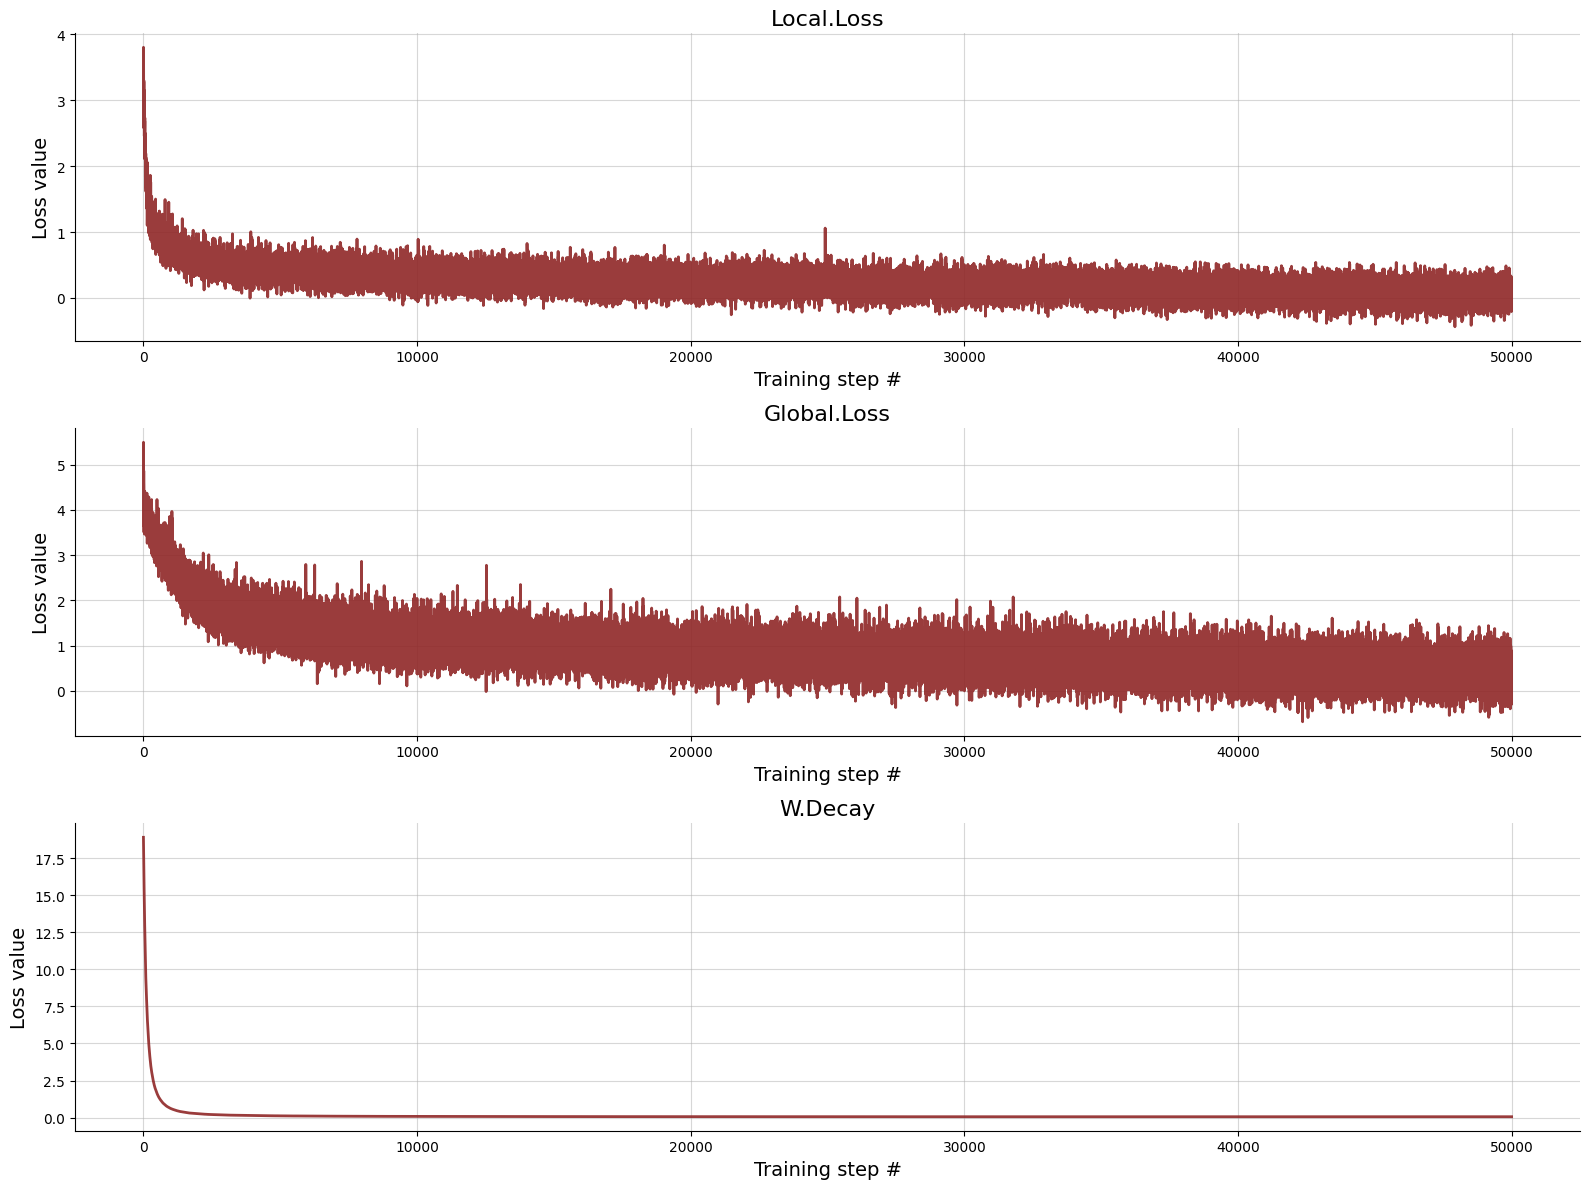

In [15]:
l = bf.diagnostics.plot_losses(train_losses=trainer.loss_history.get_plottable())

# Validation

In [214]:
val_data = configure(generative_model(1))
true_local_params = unscale_z(val_data['local_parameters'], LOCAL_PARAM_MEANS, LOCAL_PARAM_STDS)
true_shared_params = unscale_z(val_data['shared_parameters'], SHARED_PARAM_MEAN, SHARED_PARAM_STD)
true_hyper_params = unscale_z(val_data['hyper_parameters'], HYPER_PARAM_MEANS, HYPER_PARAM_STDS)

In [215]:
samples = amortizer.sample(val_data, N_SAMPLES)

## Local Params

In [216]:
local_post_samples = unscale_z(samples['local_samples'], LOCAL_PARAM_MEANS, LOCAL_PARAM_STDS)
local_post_mean = np.mean(local_post_samples, axis=1)
local_post_quantiles = np.quantile(local_post_samples, [0.025, 0.975], axis=1)

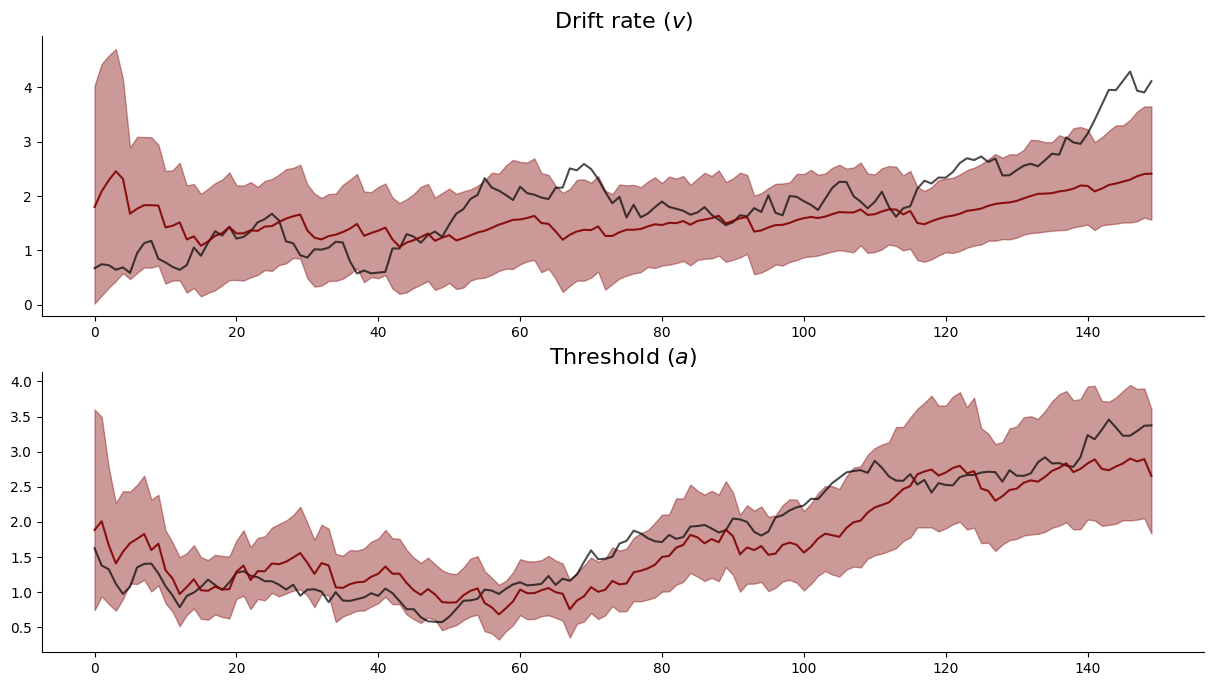

In [223]:
fig, axarr = plt.subplots(2, 1, figsize=(15, 8))
for i, ax in enumerate(axarr.flat):
    ax.plot(range(N_OBS), true_local_params[0, :, i] , color='black', alpha=0.7)
    ax.fill_between(range(N_OBS), local_post_quantiles[0, :, i], local_post_quantiles[1, :, i], color='maroon', alpha=0.4)
    ax.plot(range(N_OBS), local_post_mean[:, i], color='maroon', alpha=0.9)
    ax.set_title(f'{LOCAL_PARAM_LABELS[i]} (${LOCAL_PARAM_NAMES[i]}$)', fontsize=FONT_SIZE_1)
sns.despine()

## Global Params

In [218]:
global_post_samples_z = samples['global_samples']
hyper_post_samples_z = global_post_samples_z[:, :2]
shared_post_samples_z = global_post_samples_z[:, 2:]

hyper_post_samples = unscale_z(hyper_post_samples_z, HYPER_PARAM_MEAN, HYPER_PARAM_STD)
shared_post_samples = unscale_z(shared_post_samples_z, SHARED_PARAM_MEAN, SHARED_PARAM_STD)

global_post_samples = np.c_[hyper_post_samples, shared_post_samples]

In [219]:
prior_draws = prior(N_SAMPLES)
global_prior_draws =  np.c_[prior_draws['hyper_parameters'], prior_draws['shared_parameters']]

In [220]:
true_global_params = np.concatenate([true_hyper_params[0, :], true_shared_params[0]])

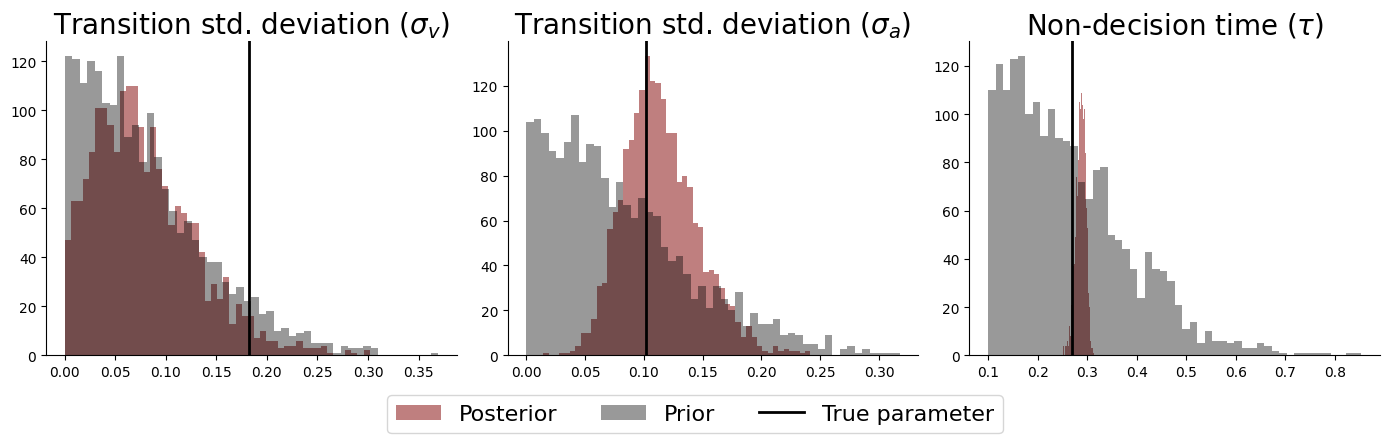

In [221]:
fig, axarr = plt.subplots(1, 3, figsize=(14, 4))
for i, ax in enumerate(axarr.flat):
    ax.hist(global_post_samples[:, i], bins=50,
            color='maroon', alpha=0.5, label='Posterior')
    ax.hist(global_prior_draws[:, i], bins=50,
                 color='black', alpha=0.4, label='Prior')
    ax.axvline(true_global_params[i], color='black',
               label='True parameter', lw=2)
    if i < 2:
        ax.set_title(f'{HYPER_PARAM_LABEL} (${HYPER_PARAM_NAME}_{LOCAL_PARAM_NAMES[i]}$)', fontsize=20)
    else:
        ax.set_title(f'{SHARED_PARAM_LABEL} (${SHARED_PARAM_NAME}$)', fontsize=20)

    if i == 0:
        fig.legend(fontsize=16, loc='center',
                 bbox_to_anchor=(0.5, -0.05), ncol=4)

fig.tight_layout()
sns.despine()

# Empirical Data

## Martins Data

In [79]:
# Data preparation

## Average Parameter Dynamic

## Absolute Fit

## Other Dataset

In [ ]:
# Data preparation

## Average Parameter Dynamic

## Absolute Fit